In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import function as func
import csv

import math

outdir = './plot/result_figure/'

# Convert the fit result $P_{\mathrm{DP}}$ to $\chi$ limit

$$
\chi = 1.248 \times 10^{-10} 
\left( 
\frac{P_{\mathrm{DP}}}{10^{-19}\,\mathrm{W}} 
\frac{10\,\mathrm{cm^2}}{A_{\mathrm{eff}}} 
\frac{0.39\,\mathrm{GeV/cm^3}}{\rho} 
\right)^{1/2} 
\frac{\sqrt{2/3}}{\alpha}
$$

係数は小高修論では $1.4\times 10^{-10}$ だったが、これは誤り


In [35]:
out_path = "/data/ms2840a/result_data/chi_limit_final2.csv"
check_freq = np.array([18190, 18336, 19120, 19186, 19440, 19478, 19766, 19794, 19818, 20006, 20296, 20302, 20490, 20540, 20892, 21442, 21808, 22522, 22672, 23306, 23808, 23934, 25328, 25352, 25860, 26274, 26346])
check_freq = check_freq*1000 - 250

A_geom = np.pi * (59.3/2*1e-3)**2 # Physical aperture
eta_eff = 0.629 #  Get from Aeff_analysis.ipnb (from HFSS simulation)
sigma_95CL = 1.715 # Get from get_N_eff.ipynb

# Systematics errors
### New 2022.04.12 S.Adachi ###
#'''
# on Aeff [from xy_scan.ipynb]
# max diff on beam width = 0.1385
# max diff on Aeff = 0.2859
# std diff on beam width = 0.04222
# std diff on Aeff = 0.0843
Aeff_errratio = 0.0843

gaindiff_errratio = 0.06835459615129354 # on P_DP [from yfactor_plot_all.ipynb]
gainTemp_errratio = (2+1)/(300-77) # on P_DP [2K error on 300K and 1K error on 77K]
gainEccosorb_errratio = 0.01*1e-2 # 0.01% reflectivity
gain_eta_win_errratio = 0.0386 # on eta_win --> P_DP [from xy_scan.ipynb]
alignment_theta_err_deg = 0.05 # deg (angle meter accuracy)
conversion_theta_err_deg = 0.06 # deg (from theory)
sigma_deg_265 = 13.95 # sigma1/2(FWHM) deg @ 26.5 GHz [from xy_analysis.ipynb]
rho_errratio = 0.077 # on rho (DM density)
binning_errratio = 1.191657 * 0.01 # [from peak_search.ipynb]
#'''

### Old ###
'''
Aeff_errratio = 0.129 # on Aeff [from xy_scan.ipynb]
gaindiff_errratio = 0.06835459615129354 # on P_DP [from yfactor_plot_all.ipynb]
gainTemp_errratio = (2+1)/(300-77) # on P_DP [2K error on 300K and 1K error on 77K]
gainEccosorb_errratio = 0.01*1e-2 # 0.01% reflectivity
gain_eta_win_errratio = 0.129 # on eta_win --> P_DP [from xy_scan.ipynb]
alignment_theta_err_deg = 0.05 # deg (angle meter accuracy)
conversion_theta_err_deg = 0.06 # deg (from theory)
sigma_deg_265 = 15. # sigma1/2 deg @ 26.5 GHz [from xy_analysis.ipynb]
rho_errratio = 0.077 # on rho (DM density)
'''


# Sum gain errors
gain_errratios = np.array([gaindiff_errratio, gainTemp_errratio, gainEccosorb_errratio, gain_eta_win_errratio])
gainTotal_errratio = np.sqrt( np.sum(np.power(gain_errratios, 2.)) ) # on P_DP
# Calculate angle errors to P_DP errors
# Old version has a mistake by Kotaka
#def get_theta_shift_err(x, sigma): return 1. - np.exp( -x/(sigma/2.))
def get_theta_shift_err(x, sigma): return 1. - np.exp( -x**2./(2.*sigma**2.))
alignment_errratio  = get_theta_shift_err(alignment_theta_err_deg, sigma_deg_265) # on P_DP from alignment of metal plate
conversion_errratio = get_theta_shift_err(conversion_theta_err_deg, sigma_deg_265) # on P_DP from conversion photon direction error

# Sum all errors on P_DP
#errratios = np.array([gainTotal_errratio, Aeff_errratio, alignment_errratio, conversion_errratio, rho_errratio])
errratios = np.array([gainTotal_errratio, Aeff_errratio, alignment_errratio, conversion_errratio, rho_errratio, binning_errratio])
power_syst_total = np.sqrt( np.sum(np.power(errratios, 2.))  )

chi_syst_total = power_syst_total/2. # This 1/2 comes from sqrt(P_DP), sqrt(1/Aeff), sqrt(1/rho)
print(chi_syst_total)
#chi_syst_total = 0.103 #  Error on chi (old value)

# Chi syst on 1sigma --> 95 % C.L.
from scipy import stats
# y=ppf(x) は -inf. ~ y  までの正規分布の積分が 100*x % になるような y を返す
# ほしいのは -inf -- +sigma_95 で 95% になる領域で片側で考える
sigma_95 = stats.norm.ppf(0.95) 
chi_syst_total_95CL = chi_syst_total * sigma_95

print('Errors on P_DP')
print(f'  from gain      = {gainTotal_errratio*100:.3f} %')
print(f'      from calib. diff = {gaindiff_errratio*100:.3f} %')
print(f'      from eta_win     = {gain_eta_win_errratio*100:.3f} %')
print(f'      from temperature = {gainTemp_errratio*100:.3f} %')
print(f'      from Eccosorb    = {gainEccosorb_errratio*100:.3f} %')
print(f'  from Aeff      = {Aeff_errratio*100:.3f} %')
print(f'  from alignment = {alignment_errratio*100:.4f} %')
print(f'  from conversion= {conversion_errratio*100:.4f} %')
print(f'  from rho       = {rho_errratio*100:.3f} %')
print(f'  from binning   = {binning_errratio*100:.3f} %')
print(f'Total error on P_DP = {power_syst_total*100:.3f} %')

print()
print('Errors on \chi')
print(f'  from gain      = {gainTotal_errratio/2.*100:.3f} %')
print(f'      from calib. diff = {gaindiff_errratio/2.*100:.3f} %')
print(f'      from eta_win     = {gain_eta_win_errratio/2.*100:.3f} %')
print(f'      from temperature = {gainTemp_errratio/2.*100:.3f} %')
print(f'      from Eccosorb    = {gainEccosorb_errratio/2.*100:.3f} %')
print(f'  from Aeff      = {Aeff_errratio/2.*100:.3f} %')
print(f'  from alignment = {alignment_errratio/2.*100:.4f} %')
print(f'  from conversion= {conversion_errratio/2.*100:.4f} %')
print(f'  from rho       = {rho_errratio/2.*100:.3f} %')
print(f'  from binning   = {binning_errratio/2.*100:.3f} %')
print(f'Total error on chi (1sigma)  = {chi_syst_total*100:.3f} %')
print(f'Total error on chi (95% C.L.)  = {chi_syst_total_95CL*100:.3f} %')

# Function of eta_window
# Obtained from Aeff_analysis.ipynb
# function(nu) = a(nu[GHz]-22 GHz) + b
# a = 0.017279 +/- 0.00018
# b = 0.238357 +/- 0.000465
def eta_win(freq, a=0.017279, b=0.238357):
    return a * (freq - 22.) + b

val_max = 0.
val_min = 1.

0.06985842200292147
Errors on P_DP
  from gain      = 7.964 %
      from calib. diff = 6.835 %
      from eta_win     = 3.860 %
      from temperature = 1.345 %
      from Eccosorb    = 0.010 %
  from Aeff      = 8.430 %
  from alignment = 0.0006 %
  from conversion= 0.0009 %
  from rho       = 7.700 %
  from binning   = 1.192 %
Total error on P_DP = 13.972 %

Errors on \chi
  from gain      = 3.982 %
      from calib. diff = 3.418 %
      from eta_win     = 1.930 %
      from temperature = 0.673 %
      from Eccosorb    = 0.005 %
  from Aeff      = 4.215 %
  from alignment = 0.0003 %
  from conversion= 0.0005 %
  from rho       = 3.850 %
  from binning   = 0.596 %
Total error on chi (1sigma)  = 6.986 %
Total error on chi (95% C.L.)  = 11.491 %


freq = 18.0 GHz
freq = 19.0 GHz
freq = 20.0 GHz
freq = 21.0 GHz
freq = 22.0 GHz
freq = 23.0 GHz
freq = 24.0 GHz
freq = 25.0 GHz
freq = 26.0 GHz
8.079389588182873e-11
2.263701350379477e-11


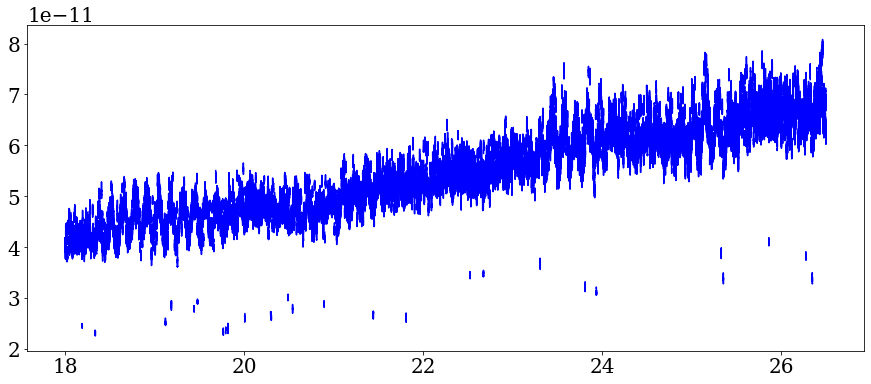

In [36]:
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 20
#fig.suptitle("Result of Exp.1 ~ Exp.4")



# Write limit in csv file
with open(out_path, "w") as f:
    writer = csv.writer(f)
    writer.writerow(["freq", "chi"])

    for i in range(180, 265, 1):
        if i%10 == 0: print(f'freq = {i*0.1} GHz')
        start_freq = i/10
        initial = int(start_freq * 1.e+6 - 250)
        final = int(initial + 1.e+5)
        for j in range(initial, final, 2000):
            word = list(str(j))
            word.insert(2, ".")
            start = "".join(word)
            val = 0
            if float(start)*1e6 in check_freq:
                path = "/data/ms2840a/result_data/check_result/fit_result/start_{}GHz.csv".format(start)
                data = func.csv_to_array(path)
                val = np.max(data["P"],0) + sigma_95CL*data["P_err"]
            else:
                path = "/data/ms2840a/result_data/fit_result/start_{}GHz.csv".format(start)
                data = func.csv_to_array(path)
                val = np.max(data["P"],0) + sigma_95CL*data["P_err"]
                pass
                         
            # Upper limit on P_DP (val) --> Upper limit on Chi + syst. uncertaintis (1.103) 
            #chi = (1.+chi_syst_total) * 1.4e-10 * (val * eta_win(data["freq_0"]/1e9) / 1e-19)**0.5 * (1e-3 / (A_geom*eta_eff))**0.5
            chi = (1.+chi_syst_total_95CL) * 1.248e-10 * (val * eta_win(data["freq_0"]/1e9) / 1e-19)**0.5 * (1e-3 / (A_geom*eta_eff))**0.5
            plt.plot(data["freq_0"]/1e9, chi, color="blue")
            val_max = max(val_max, np.max(chi))
            val_min = min(val_min, np.min(chi))
            
            for freq, chi in zip(data['freq_0'], chi):
                writer.writerow([freq*1e-9, chi])
                pass
            pass
        pass
    pass

print(val_max)
print(val_min)

{'freq': array([18.      , 18.000002, 18.000004, ..., 26.499994, 26.499996,
       26.499998]), 'chi': array([4.16315707e-11, 4.15749646e-11, 4.16077195e-11, ...,
       6.47793321e-11, 6.48030938e-11, 6.47198463e-11])}


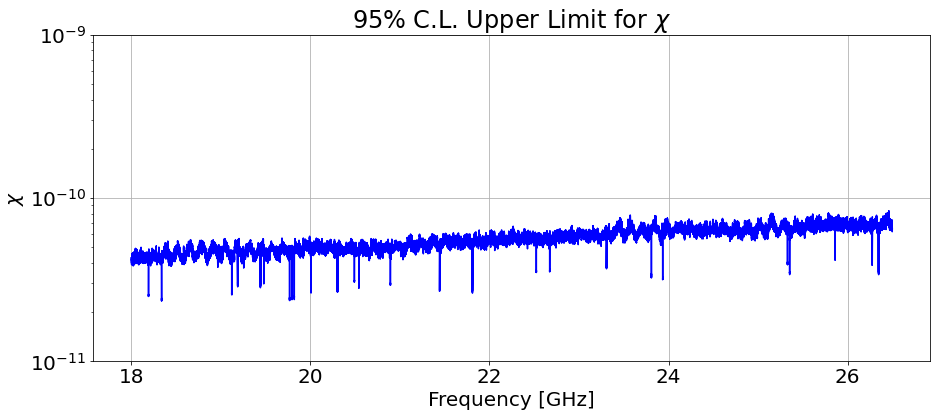

In [12]:
data = func.csv_to_array(out_path)
print(data)

plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 20
plt.plot(data["freq"], data["chi"], color="blue")
plt.grid()
plt.yscale("log")
plt.title(r"95% C.L. Upper Limit for $\chi$")
plt.ylabel(r"$\chi$")
plt.xlabel("Frequency [GHz]")
plt.ylim([1e-11, 1e-9])

plt.savefig(f"{outdir}/limit_chi.pdf")

In [30]:
print(eta*A_geom)

0.0017399622161914604


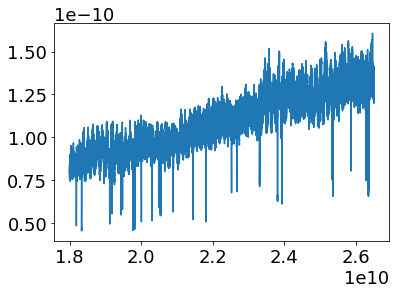

In [30]:
data = func.csv_to_array("/data/ms2840a/result_data/chi_limit.csv")
plt.plot(data["freq[Hz]"], data["chi"])

In [25]:
A_geom*eta

0.0009114087799098127

In [28]:
def plot_add_spec(ax, num):
    

    check_freq = np.array([18190, 18336, 19120, 19186, 19440, 19478, 19766, 19794, 19818, 20006, 20296, 20302, 20490, 20540, 20892, 21442, 21808, 22522, 22672, 23306, 23808, 23934, 25328, 25352, 25860, 26274, 26346])

    line = np.array([
        18.190812,
        18.336724,
        19.120514,
        19.187772,
        19.441606,
        19.479506,
        19.766974,
        19.794366,
        19.819072,
        20.007980,
        20.296620,
        20.302788,
        20.490250,
        20.541586,
        20.893242,
        21.443168,
        21.808598,
        22.522234,
        22.673946,
        23.307606,
        23.808666,
        23.935386,
        25.329956,
        25.353898,
        25.860092,
        26.274234,
        26.347692])
    
    word = list(str(check_freq[num]*1000 - 250))
    word.insert(2, ".")
    start = "".join(word)

    path = "/data/ms2840a/result_data/check_result/signal_p_local_mean_fit/start_{}GHz.csv".format(start)
    data1 = func.csv_to_array(path)

    ax.plot((data1["freq_0"]/1e+9 - np.floor(line[num]*100)/100)*1e3, data1["p_local"], color="blue")
    ax.axvline(x = (line[num] - np.floor(line[num]*100)/100)*1e3, color="red", linestyle='--')
    ax.grid()
    ax.set_yscale("log")
    ax.set_xlabel("Frequency [MHz + {} GHz]".format(np.floor(line[num]*100)/100))
    ax.set_ylabel(r"$p_{\rm local}$")
    ax.set_ylim([5e-6, 2])
    ax.set_yticks([1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
    
    title = ""
    if num+1 == 1 or num+1 == 11 or num+1 == 21: title = str(num+1) + "st"
    elif num+1 == 2 or num+1 == 12 or num+1 == 22: title = str(num+1) + "nd"
    elif num+1 == 3 or num+1 == 13: title = str(num+1) + "rd"
    else: title = str(num+1) + "th"
    ax.set_title(title + r": $\nu_0 = {} ~\rm GHz$".format(line[num]))

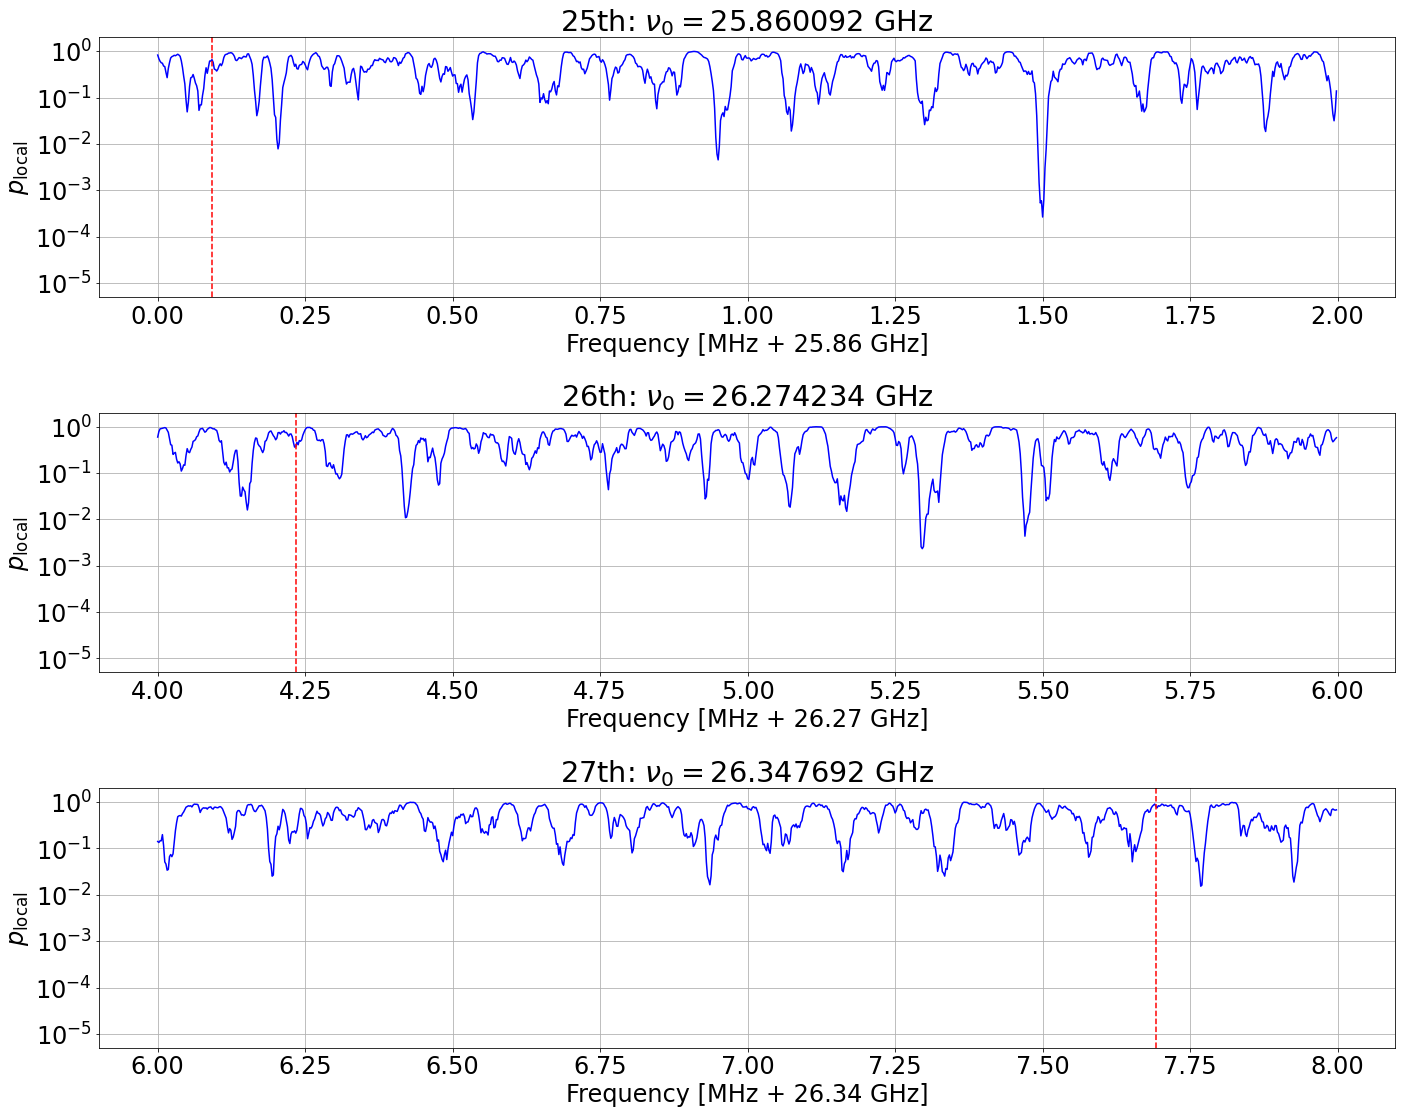

In [34]:
fig, axes = plt.subplots(3,1,figsize=(20,16), squeeze=False)
plt.rcParams["font.size"] = 24

for i in range(3):
    plot_add_spec(axes[i][0], i+24)
                    
fig.tight_layout()

plt.savefig("../result_figure/under_1e5/from25to27_add.pdf")

# Plot P_DP & p_local

In [20]:
outdir = './plot/result_figure/fit_result'
if not os.path.isdir(outdir): os.makedirs(outdir)
    

check_freq = np.array([18190, 18336, 19120, 19186, 19440, 19478, 19766, 19794, 19818, 20006, 20296, 20302, 20490, 20540, 20892, 21442, 21808, 22522, 22672, 23306, 23808, 23934, 25328, 25352, 25860, 26274, 26346])
check_freq = check_freq*1000 - 250

W_conv = 1.e+18 # convert to aW

freq_P_before = []
freq_P_after = []
freq_before = []
freq_after = []
y_P_after = []
y_P_before = []
y_before = []
y_after = []
for i in range(180, 265, 1):
    start_freq = i/10
    initial = int(start_freq * 1.e+6 - 250)
    final = int(initial + 1.e+5)

    for j in range(initial, final, 2000):
        word = list(str(j))
        word.insert(2, ".")
        start = "".join(word)

        if float(start)*1e6 in check_freq:
            # P_DP before
            path = "/data/ms2840a/result_data/fit_result/start_{}GHz.csv".format(start)
            data = func.csv_to_array(path)
            freq_P_before.append(data['freq_0'])
            y_P_before.append(data['P'])
 
            # P_DP after
            path = "/data/ms2840a/result_data/check_result/fit_result_mean_W/start_{}GHz.csv".format(start)
            data = func.csv_to_array(path)
            freq_P_after.append(data['freq_0'])
            y_P_after.append(data['P'])
 
            # p_local before
            path = "/data/ms2840a/result_data/signal_p_local/start_{}GHz.csv".format(start)
            data = func.csv_to_array(path)
            freq_before.append(data['freq_0'])
            y_before.append(data['p_local'])
            
            # p_local after
            path = "/data/ms2840a/result_data/check_result/signal_p_local_mean_W/start_{}GHz.csv".format(start)
            data = func.csv_to_array(path)
            freq_after.append(data['freq_0'])
            y_after.append(data['p_local'])
        else:
            # P_DP
            path = "/data/ms2840a/result_data/fit_result/start_{}GHz.csv".format(start)
            data = func.csv_to_array(path)
            freq_P_before.append(data['freq_0'])
            y_P_before.append(data['P'])
            freq_P_after.append(data['freq_0'])
            y_P_after.append(data['P'])

            # p_local before
            path = "/data/ms2840a/result_data/signal_p_local/start_{}GHz.csv".format(start)
            data = func.csv_to_array(path)
            freq_before.append(data['freq_0'])
            y_before.append(data['p_local'])
            freq_after.append(data['freq_0'])
            y_after.append(data['p_local'])
            pass
        pass

    pass

freq_P_before = np.array(freq_P_before)
freq_P_after = np.array(freq_P_after)
freq_before = np.array(freq_before)
freq_after = np.array(freq_after)
y_P_before = np.array(y_P_before)
y_P_after = np.array(y_P_after)
y_before = np.array(y_before)
y_after = np.array(y_after)

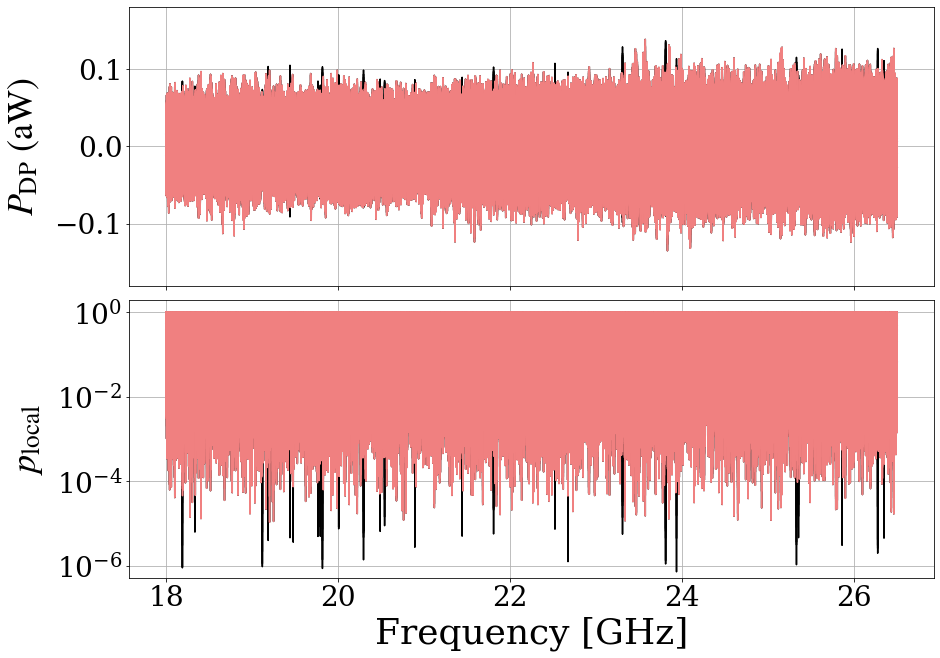

In [31]:
fig, axes = plt.subplots(2,1,figsize=(14,10), squeeze=False, sharex=True)
#after_color='indianred'
after_color='lightcoral'
fig.tight_layout()
axes[0][0].plot(freq_P_before*1.0e-9, y_P_before*W_conv, color='black')
axes[0][0].plot(freq_P_after*1.0e-9, y_P_after*W_conv, color=after_color)
axes[1][0].plot(freq_before*1.0e-9, y_before, color='black')
axes[1][0].plot(freq_after*1.0e-9, y_after, color=after_color)

plt.rcParams["font.size"] = 28
plt.rcParams["mathtext.fontset"] = 'stix'
plt.rcParams["font.family"] = 'serif'

ax = axes[0][0]
ax.grid()
ax.set_ylim([-0.18, 0.18])
ax.set_ylabel(r"$P_{\rm DP} ~(\mathrm{aW})$", labelpad=12, fontsize=36)
ax = axes[1][0]
ax.grid()
ax.set_yscale("log")
ax.set_ylabel(r"$p_{\rm local}$", labelpad=12, fontsize=36)
ax.set_yticks([1e-0, 1e-2, 1e-4, 1e-6])
ax.set_xlabel("Frequency [GHz]", fontsize=36)
ax.set_ylim([5e-7, 2])

fig.subplots_adjust(hspace=0.05, left=0.15, bottom=0.15)

In [32]:
#fig.savefig(f'{outdir}/plocal_after_gray.png')
fig.savefig(f'{outdir}/plocal_after_{after_color}.png')
#fig.savefig(f'{outdir}/plocal_after_gray.pdf') # --> Too large

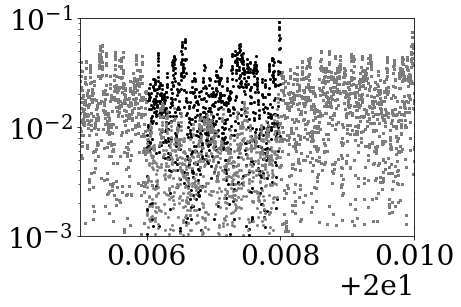

In [146]:
# Check for difference before & after zooming in 20GHz
diff_freq = freq_P_after
diff = y_P_after - y_P_before
#plt.plot(diff_freq*1.0e-9, diff)
plt.plot(diff_freq*1.0e-9, abs(y_P_before*W_conv), c='black', linestyle='', marker='o', markersize=2.0)
plt.plot(diff_freq*1.0e-9, abs(y_P_after*W_conv), c='gray', linestyle='', marker='o', markersize=2.0)
plt.xlim(20.005,20.01)
plt.ylim(1e-3,1e-1)
plt.yscale('log')

# Plot Powers

In [12]:
for i in range(180, 265, 1):
    start_freq = i/10
    initial = int(start_freq * 1.e+6 - 250)
    final = int(initial + 1.e+5)

    for j in range(initial, final, 2000):
        word = list(str(j))
        word.insert(2, ".")
        start = "".join(word)
        
        freq = 
        for num in range(12):
            path = "/data/ms2840a/signal_raw_data/scan_FFT_{}GHz_span2.50MHz_rbw0.3kHz_2.0sec_1counts_12runs_{}.dat".format(start, num)
            freq, W = func.dat_to_array(path)
        W = (data["W_0"]+data["W_1"]+data["W_2"]+data["W_3"]+data["W_4"]+data["W_5"]
        +data["W_6"]+data["W_7"]+data["W_8"]+data["W_9"]+data["W_10"]+data["W_11"])/12
        freq, W = func.cut_data(data["freq"], W)
        freq, W, Wstd = func.rebin_func(freq, W)
        
        with open("/data/ms2840a/result_data/real_data.csv", "a") as f:
            writer = csv.writer(f)
            for p in range(len(freq)):
                writer.writerow([freq[p], W[p], Wstd[p]])

In [2]:
data1 = func.csv_to_array("/data/ms2840a/result_data/signal_raw_data.csv")
data2 = func.csv_to_array("/data/ms2840a/result_data/real_data.csv")

data1 = func.csv_to_array()
data2 = func.csv_to_array("/data/ms2840a/result_data/real_data.csv")

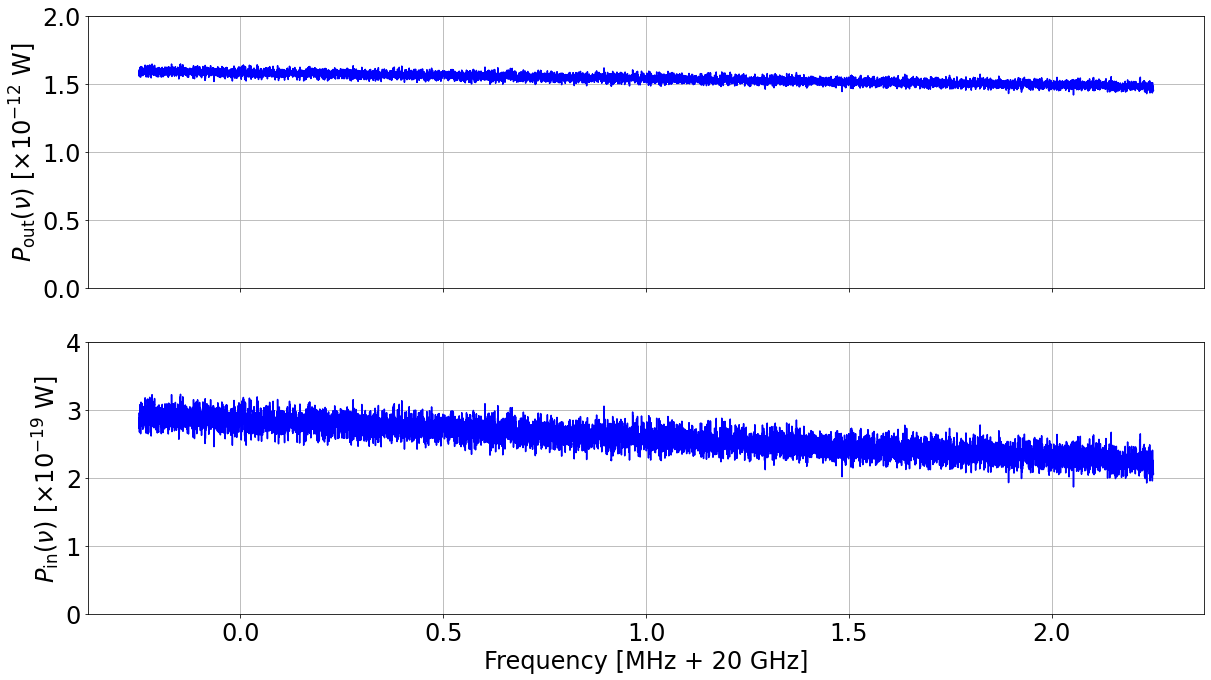

In [14]:
plt.rcParams["font.size"] = 24
fig, axes = plt.subplots(2,1,figsize=(20,11), squeeze=False, sharex=True)

path = "/data/ms2840a/signal_raw_data/scan_FFT_19.999750GHz_span2.50MHz_rbw0.3kHz_2.0sec_1counts_12runs"
Watt = []
for i in range(12):
    Watt.append(func.dat_to_array(path + "_{}.dat".format(i))[1])
    freq = func.dat_to_array(path + "_{}.dat".format(i))[0]
    
W = np.zeros(0)
for i in range(len(Watt[0])):
    W = np.append(W, np.mean(np.array([Watt[j][i] for j in range(12)])))

ax = axes[0][0]
ax.plot((freq/1e9-20)*1e3, W*1e12, color="blue")
ax.grid()
ax.set_ylim([0,2])
#ax.set_yticks([-90,-85,-80])
ax.set_ylabel(r"$P_{\rm out}(\nu) ~[\times 10^{-12} ~\rm W]$")


path = "/data/ms2840a/result_data/signal_12_data/start_19.999750GHz.csv"
Watt = []
for i in range(12):
    Watt.append(func.csv_to_array(path)["W_{}".format(i)])
    freq = func.csv_to_array(path)["freq"]
    
W = np.zeros(0)
for i in range(len(Watt[0])):
    W = np.append(W, np.mean(np.array([Watt[j][i] for j in range(12)])))


ax = axes[1][0]
ax.plot((freq/1e9-20)*1e3, W*1e19, color="blue")
ax.set_ylim([0,4])
#ax.set_yticks([-160,-155,-150])
ax.set_ylabel(r"$P_{\rm in}(\nu) ~[\times 10^{-19} ~\rm W]$")
ax.set_xlabel("Frequency [MHz + 20 GHz]")
ax.grid()

plt.savefig("../result_figure/fit_result/raw_data.pdf")

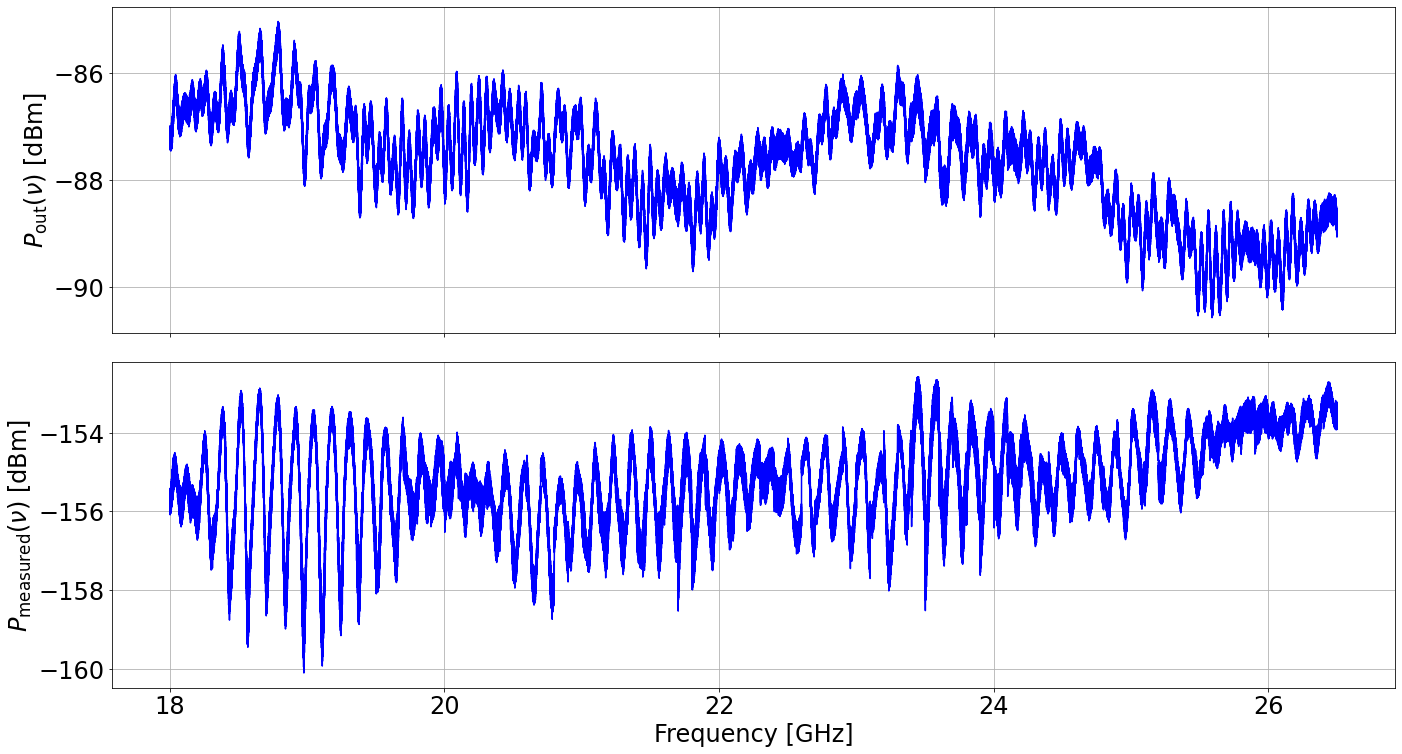

In [5]:
plt.rcParams["font.size"] = 24
fig, axes = plt.subplots(2,1,figsize=(20,11), squeeze=False, sharex=True)
#fig.suptitle("Result of Exp.1 ~ Exp.4")

ax = axes[0][0]

ax.plot(data1["freq"], np.log10(data1["W"]*1000)*10, color="blue")
ax.grid()
ax.set_ylabel(r"$P_{\rm out}(\nu)$ [dBm]")

ax = axes[1][0]

ax.plot(data2["freq"]/1e9, np.log10(data2["W_mean"]*1000)*10, color="blue")
ax.grid()
ax.set_ylabel(r"$P_{\rm measured}(\nu)$ [dBm]")
ax.set_xlabel("Frequency [GHz]")
                    
fig.tight_layout()

plt.savefig("../result_figure/fit_result/raw_data.pdf")

In [2]:
def p_glob(x):
    return 1-(1-x)**(4.25e6*0.38)

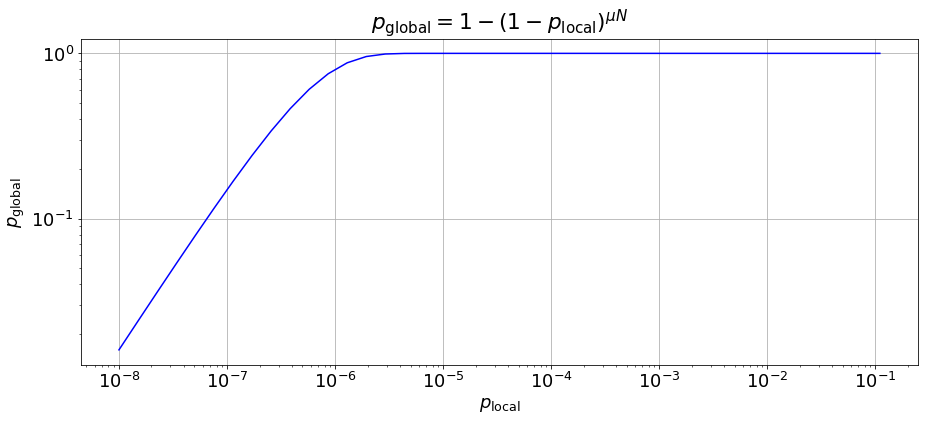

In [11]:
x = np.array([1e-8])
while x[-1] < 0.1:
    xx = x[-1]*1.5
    x = np.append(x, xx)

plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18
plt.plot(x, p_glob(x), color="blue")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$p_{\rm local}$")
plt.ylabel(r"$p_{\rm global}$")
plt.title(r"$p_{\rm global} = 1 - (1 - p_{\rm local})^{\mu N}$")
plt.grid()
plt.savefig("../result_figure/N_eff/p_global.pdf")